In [111]:
import pandas as pd
import numpy as np
import gurobipy as gp
from gurobipy import GRB
import csv
import networkx as nx
import matplotlib.pyplot as plt
import math


In [112]:
m = gp.Model('Maritime Inventory Routing Problem')

# Creating classes in order organize the code

In [113]:
class Port:
    def __init__(self, capacity, inventory, rate, price, berth_limit, port_fee, max_amount, min_amount, number, isLoadingPort):
        self.capacity = capacity
        self.inventory = inventory
        self.rate = rate
        self.price = price 
        self.berth_limit = berth_limit 
        self.port_fee = port_fee
        self.max_amount = max_amount
        self.min_amount = min_amount
        self.number = number
        self.isLoadingPort = isLoadingPort
        
    def __repr__(self):
        return f'Port {self.number}'
    

class Node:
    def __init__(self, port, time):
        self.port = port
        self.time = time
        self.tuple = (port.number if port else None, time)
        self.incoming_arcs = set()
        self.outgoing_arcs = set()
        self.berths = port.berth_limit if port else None
    
    def __repr__(self):
        return str(self.tuple)


class Arc:
    def __init__(self, origin_node, destination_node, distance, cost, travel_time, speed):
        self.origin_node = origin_node
        self.destination_node = destination_node
        self.tuple = (origin_node, destination_node)
        self.distance = distance
        self.cost = cost
        self.travel_time = travel_time
        self.speed = speed
            
    def __repr__(self):
        return f'{self.origin_node} -> {self.destination_node} --- Cost: {self.cost} --- Speed: {self.speed}'

class Vessel:
    def __init__(self, max_inventory, initial_inventory, max_operating_quantity, number):
        self.max_inventory = int(max_inventory)
        self.inventory = initial_inventory
        self.max_operating_quantity = max_operating_quantity
        self.number = number
        self.arcs = set()
        
    def __repr__(self):
        return f'Vessel {self.number}'
        

### Read in file

In [114]:
# Read the content of the provided file
with open("data/LR1_1_DR1_3_VC1_V7a.txt", 'r') as file:
    content = file.read()

In [115]:
def parse_metadata(content):
    metadata = {}
    
    # Extract lines between "----- MetaData -----" and the next section separator (empty line or end of file)
    start_index = content.index("----- MetaData -----") + len("----- MetaData -----")
    end_index = content.find("\n\n", start_index) if "\n\n" in content[start_index:] else len(content)
    metadata_section = content[start_index:end_index].strip().split("\n")
    
    for line in metadata_section:
        if ":" in line:
            # Split the line at ":" to extract the key and value
            key, value = line.split(":")
            # Store the key-value pair in the dictionary
            metadata[key.strip()] = value.strip()
    
    return metadata

## Read in metadata

In [116]:
'''Are not using these values:
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))'''

def read_and_assign_metadata_from_content(content):
    # Parse the metadata
    metadata = parse_metadata(content)
    
    # Assign the metadata values to variables
    numPeriods = int(metadata['numPeriods'].split()[-1])  # Extract the last word (number) from the string
    numCommodities = int(metadata['numCommodities'])
    numLoadingRegions = int(metadata['numLoadingRegions'])
    numDischargingRegions = int(metadata['numDischargingRegions'])
    numLoadingPortsInRegion = [int(x) for x in metadata['numLoadingPortsInRegion'][1:-1].split()]
    numDischargingPortsInRegion = [int(x) for x in metadata['numDischargingPortsInRegion'][1:-1].split()]
    numVesselClasses = int(metadata['numVesselClasses'])
    numTermVesselsInClass = [int(x) for x in metadata['numTermVesselsInClass'][1:-1].split()]
    hoursPerPeriod = int(metadata['hoursPerPeriod'])
    spotMarketPricePerUnit = float(metadata['spotMarketPricePerUnit'])
    spotMarketDiscountFactor = float(metadata['spotMarketDiscountFactor'])
    perPeriodRewardForFinishingEarly = float(metadata.get('perPeriodRewardForFinishingEarly', 0))
    attemptCost = float(metadata.get('attemptCost', 0))
    constantForSinglePeriodAlphaSlack = float(metadata.get('constantForSinglePeriodAlphaSlack', 0))
    constantForCumulativeAlphaSlack = float(metadata.get('constantForCumulativeAlphaSlack', 0))
    
    # Return the assigned variables
    return {
        'numPeriods': numPeriods,
        'numCommodities': numCommodities,
        'numLoadingRegions': numLoadingRegions,
        'numDischargingRegions': numDischargingRegions,
        'numLoadingPortsInRegion': numLoadingPortsInRegion,
        'numDischargingPortsInRegion': numDischargingPortsInRegion,
        'numVesselClasses': numVesselClasses,
        'numTermVesselsInClass': numTermVesselsInClass,
        'hoursPerPeriod': hoursPerPeriod,
        'spotMarketPricePerUnit': spotMarketPricePerUnit,
        'spotMarketDiscountFactor': spotMarketDiscountFactor,
        'perPeriodRewardForFinishingEarly': perPeriodRewardForFinishingEarly,
        'attemptCost': attemptCost,
        'constantForSinglePeriodAlphaSlack': constantForSinglePeriodAlphaSlack,
        'constantForCumulativeAlphaSlack': constantForCumulativeAlphaSlack}

In [117]:

# Using the refactored function with the already-read content
metadata_from_content = read_and_assign_metadata_from_content(content)
# Change the numPeriods manually.
metadata_from_content['numPeriods'] = 15
metadata_from_content

{'numPeriods': 15,
 'numCommodities': 1,
 'numLoadingRegions': 1,
 'numDischargingRegions': 1,
 'numLoadingPortsInRegion': [1],
 'numDischargingPortsInRegion': [3],
 'numVesselClasses': 1,
 'numTermVesselsInClass': [7],
 'hoursPerPeriod': 24,
 'spotMarketPricePerUnit': 1.0,
 'spotMarketDiscountFactor': 0.999,
 'perPeriodRewardForFinishingEarly': 0.01,
 'attemptCost': 0.01,
 'constantForSinglePeriodAlphaSlack': 0.5,
 'constantForCumulativeAlphaSlack': 1.0}

### Read in port data

In [118]:
def parse_region_table(content):
    # Extract the region table section
    start_index = content.index("----- Region Table ----") + len("----- Region Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    region_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    regions = {}
    for line in region_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            regions[attribute] = values
    return regions


def parse_port_table_for_region(content, region_index):
    # Extract the port table section for the specified region
    search_str = f"----- Port Table For Region {region_index} ----"
    start_index = content.index(search_str) + len(search_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    port_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    ports = {}
    for line in port_section:
        attribute, *values = line.split()
        ports[attribute] = values
    return ports


In [119]:
# Extract region and port information
regions_info = parse_region_table(content)
ports_info = {f"Region {i}": parse_port_table_for_region(content, i) for i in range(len(regions_info['NumPorts']))}
ports_info

{'Region 0': {'Capacity': ['594'],
  'Inventory': ['297'],
  'Rate': ['99'],
  'Price': [],
  'BerthLimit': ['1'],
  'PortFee': ['38'],
  'maxAmt': ['300'],
  'minAmt': ['35'],
  'C2R': ['ratio', '6']},
 'Region 1': {'Capacity': ['351', '510', '312'],
  'Inventory': ['168', '255', '156'],
  'Rate': ['-39', '-34', '-26'],
  'Price': ['5', '5', '5'],
  'BerthLimit': ['1', '1', '1'],
  'PortFee': ['57', '58', '66'],
  'maxAmt': ['300', '300', '259'],
  'minAmt': ['50', '35', '20'],
  'C2R': ['ratio', '9', '15', '12']}}

### Create the ports

In [120]:
def create_ports_from_info_with_loading(ports_info):
    all_ports = {}
    tot_num = 1
    
    for region_idx, (region, port_attributes) in enumerate(ports_info.items()):
        region_ports = []
        for i in range(len(port_attributes['Capacity'])):
            port = Port(
                capacity=int(port_attributes['Capacity'][i]) if 'Capacity' in port_attributes else None,
                inventory=int(port_attributes['Inventory'][i]) if 'Inventory' in port_attributes else None,
                rate=abs(int(port_attributes['Rate'][i])) if 'Rate' in port_attributes else None,
                price=int(port_attributes['Price'][i]) if 'Price' in port_attributes and port_attributes['Price'] else None,
                berth_limit=int(port_attributes['BerthLimit'][i]) if 'BerthLimit' in port_attributes else None,
                port_fee=int(port_attributes['PortFee'][i]) if 'PortFee' in port_attributes else None,
                max_amount=int(port_attributes['maxAmt'][i]) if 'maxAmt' in port_attributes else None,
                min_amount=int(port_attributes['minAmt'][i]) if 'minAmt' in port_attributes else None,
                number=int(tot_num),  # Using 1 to numports+1 as the port number
                isLoadingPort=1 if region_idx == 0 else -1)  # Set loadingPort to True if the region is the first one
            region_ports.append(port)
            tot_num += 1
        all_ports[region] = region_ports
    return all_ports

In [121]:
all_ports = create_ports_from_info_with_loading(ports_info)

In [122]:
# Create a list of all ports
ports = []
for region, region_ports in all_ports.items():
    ports.extend(region_ports)
ports

[Port 1, Port 2, Port 3, Port 4]

# Initial Parameters

All parameters should be set below

In [123]:
# Time periods
numTimePeriods = metadata_from_content['numPeriods']
timePeriodRange = list(range(1, numTimePeriods+1))

# Number of vessels
numVessels = metadata_from_content['numTermVesselsInClass'][0]

# Speed interval
max_speed_k = 15
min_speed_k = 8

# Fuel price in USD per ton
fuel_price = 500


In [124]:
def parse_vessel_table(content):
    # Extract the vessel table section
    start_index = content.index("----- Vessel Table ----") + len("----- Vessel Table ----")
    end_index = content.find("-----", start_index)  # Find the next section separator
    vessel_section = content[start_index:end_index].strip().split("\n")[1:]  # Exclude the header line
    
    vessels = {}
    for line in vessel_section:
        if "Note:" not in line:  # Exclude the note lines
            attribute, *values = line.split()
            vessels[attribute] = values
    return vessels

In [125]:
# Extract vessel information
vessels_info = parse_vessel_table(content)
vessels_info

{'Type': ['Term', 'Term', 'Term', 'Term', 'Term', 'Term', 'Term'],
 'Class': ['0', '0', '0', '0', '0', '0', '0'],
 'Capacity': ['300', '300', '300', '300', '300', '300', '300']}

In [126]:
# Create a dictionary with key = vessel class and value = vessel object
vessels = {}
tot = 1
for vessel_class in range(metadata_from_content['numVesselClasses']):
    vessel_list = []
    vessels_in_class = metadata_from_content['numTermVesselsInClass'][vessel_class]
    for i in range(vessels_in_class):
        vessel_list.append(Vessel(
            max_inventory=int(vessels_info['Capacity'][i]),
            initial_inventory=int(0),
            max_operating_quantity=int(vessels_info['Capacity'][i]),
            number=tot
        ))
        tot += 1
    vessels[vessel_class] = vessel_list

# We only have one vessel class. Convert the dictionary to a list
vessels = vessels[0]
vessels


[Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]

In [127]:
# Create the regular nodes
regularNodes = []
for t in range(1, numTimePeriods+1):
    for port in ports:
        node = Node(port=port, time=t)
        regularNodes.append(node)
    
# Create fictional source and sink port
sourcePort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=0, isLoadingPort=True)
sinkPort = Port(capacity=None, inventory=None, rate=None, price=None, berth_limit=len(vessels), port_fee=0, max_amount=None, min_amount=None, number=len(ports)+1, isLoadingPort=False)

# Create source and sink node
sourceNode = Node(port=sourcePort, time=0)
sinkNode = Node(port=sinkPort, time=numTimePeriods+1)

nodes = [sourceNode] + regularNodes + [sinkNode]

# Create a node dictionary with key = (port, time) tuple and value = node object
nodeDict = {}
for node in nodes:
    nodeDict[node.tuple] = node

### Read in arc data

In [128]:
def parse_full_distance_matrix(content):
    # Extract the full distance matrix section
    start_str = "----- FullDistanceMatrix ----"
    start_index = content.index(start_str) + len(start_str)
    end_index = content.find("-----", start_index)  # Find the next section separator
    matrix_section = content[start_index:end_index].strip().split("\n")[2:]  # Exclude the header lines
    
    # Convert the matrix section to a 2D list of distances
    distances = []
    for line in matrix_section:
        try:
            distance_row = list(map(float, line.split()[1:]))  # Excluding the leading port number
            distances.append(distance_row)
        except ValueError:
            continue
    
    return distances

# Extracting the full distance matrix from the file content
full_distance_matrix = parse_full_distance_matrix(content)
full_distance_matrix


[[0.0, 5792.83, 5730.94, 5663.71],
 [5792.83, 0.0, 326.1, 338.92],
 [5730.94, 326.1, 0.0, 67.42],
 [5663.71, 338.92, 67.42, 0.0]]

In [129]:
# Convert full_distance_matrix from km to nautical miles
# 1 nautical mile = 1.852 km
def km_to_nautical_miles(km):
    return km / 1.852

In [130]:
def convert_matrix_to_nautical_miles(matrix):
    return [[km_to_nautical_miles(distance) for distance in row] for row in matrix]

In [131]:
full_distance_matrix_nm = convert_matrix_to_nautical_miles(full_distance_matrix)
full_distance_matrix_nm

[[0.0, 3127.8779697624186, 3094.460043196544, 3058.158747300216],
 [3127.8779697624186, 0.0, 176.07991360691145, 183.00215982721383],
 [3094.460043196544, 176.07991360691145, 0.0, 36.40388768898488],
 [3058.158747300216, 183.00215982721383, 36.40388768898488, 0.0]]

In [132]:
def fuel_consumption_speed_nm(speed, nautical_miles):
    """
    Calculate the fuel consumption based on speed and nautical miles.

    Args:
    - speed (float): Speed of the vessel in knots.
    - nautical miles (float): .

    Returns:
    - float: Fuel consumption in tons.
    """
    return  (0.16 * (speed / 14) ** 3) * nautical_miles
    


# def fuel_consumption_func(speed, days):
#     """
#     Calculate the fuel consumption based on speed and days.

#     Args:
#     - speed (float): Speed of the vessel in knots.
#     - days (float): Duration in days.

#     Returns:
#     - float: Fuel consumption in tons.
#     """
#     return  (50 * (speed / 14) ** 3) * days


def calc_cost(fuel_consumption):
    """
    Calculate the cost based on fuel consumption.

    Args:
    - fuel_consumption (float): Fuel consumption in tons.

    Returns:
    - float: Cost in USD.
    """
    return fuel_consumption * 500

# Function to calculate discrete max speed based on distance and global max speed
def calculate_minimum_timesteps_and_speed(distance_nm, max_speed_k, min_speed_k):
    """
    Determine the minimum timesteps and speed based on distance and max speed.

    Args:
    - distance_nm (float): Distance in nautical miles.
    - max_speed_k (float): Maximum speed in knots.
    - min_speed_k (float): Minimum speed in knots.

    Returns:
    - tuple: Minimum timesteps and speed.
    """
    hours = distance_nm / max_speed_k
    minimum_timesteps = math.ceil(hours / 24)
    speed = distance_nm / (minimum_timesteps * 24)
    return minimum_timesteps, max(speed, min_speed_k)
    
# Based on rounded_hours and speed calculate the next speeds
def create_arc_info(speed, minimum_timesteps, departure, origin_port, destination_port, lowest_speed, distance_to_port, vessel):
    # Create a list of tuples with the speed and the time period
    '''arc_info: (speed in knots, timesteps for sailing, time period of departure, time period of arrival, origin port, destination port, fuel_consumption)'''
    
    arrival_time = departure + minimum_timesteps
    if arrival_time > numTimePeriods:
        return None
    else:
        fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
        arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port, vessel)]
    
        timesteps = minimum_timesteps+1
        while True:
            
            # Calculate the next speed
            speed = distance_to_port / ((timesteps)*24)
            # If the speed is lower than the lowest speed, break the loop
            if speed < lowest_speed:
                break
            fuel_consumption = fuel_consumption_speed_nm(speed=speed, nautical_miles=distance_to_port)
            arrival_time = departure + timesteps
            # Otherwise, add the speed to the list
            arc_info.append((speed, timesteps, departure, arrival_time, origin_port, destination_port, fuel_consumption, distance_to_port, vessel))
            # Increment the time period
            timesteps += 1
            arrival_time = departure + timesteps
            if arrival_time > numTimePeriods:
                break
       
    return arc_info
        

### Need to have starting positions for each vessel. 
### That way we can find the earliest time a vessel can be at each port.

For now we just randomly generate distances to each of the ports, without thinking about whether it is practically possible to have these distances. 

In [133]:
# Ensure reproducibility of the random numbers
np.random.seed(0)

source_distances = {}
# Creating manual starting positions for the vessels
for vessel in vessels:
    # Create a list of the distance from the source node to each of the ports
    '''
        0.00  5792.83  5730.94  5663.71 
    1  5792.83     0.00   326.10   338.92 
    2  5730.94   326.10     0.00    67.42 
    3  5663.71   338.92    67.42     0.00 
    '''
    # Randomly generate 4 distances for each vessel
    distances = np.random.randint(0, 2000, size=len(ports))
    source_distances[vessel] = distances
    
source_distances
   

{Vessel 1: array([ 684,  559, 1653, 1216]),
 Vessel 2: array([ 835,  763, 1731, 1383]),
 Vessel 3: array([1033, 1747,  277, 1778]),
 Vessel 4: array([1828,  599, 1094, 1496]),
 Vessel 5: array([ 600, 1420,  314,  705]),
 Vessel 6: array([1510,  551,   87,  174]),
 Vessel 7: array([1624,  849, 1701,  537])}

In [134]:
# Use the source_distances to create a source_times dictionary
source_times = {}
for vessel, distances in source_distances.items():
    source_times[vessel] = [math.ceil((distance / max_speed_k)/24) for distance in distances]
    
source_times

{Vessel 1: [2, 2, 5, 4],
 Vessel 2: [3, 3, 5, 4],
 Vessel 3: [3, 5, 1, 5],
 Vessel 4: [6, 2, 4, 5],
 Vessel 5: [2, 4, 1, 2],
 Vessel 6: [5, 2, 1, 1],
 Vessel 7: [5, 3, 5, 2]}

In [135]:
# Create a source_fuel_consumption as well
source_fc = {}
for vessel, distances in source_distances.items():
    source_fc[vessel] = [fuel_consumption_speed_nm(speed=max_speed_k, nautical_miles=distance)for distance in distances]
source_fc

{Vessel 1: [134.6064139941691,
  110.00728862973762,
  325.298833819242,
  239.3002915451895],
 Vessel 2: [164.32215743440233,
  150.1530612244898,
  340.64868804664724,
  272.16472303206996],
 Vessel 3: [203.28717201166182,
  343.7973760932945,
  54.511661807580175,
  349.8979591836735],
 Vessel 4: [359.73760932944606,
  117.8790087463557,
  215.29154518950438,
  294.4023323615161],
 Vessel 5: [118.07580174927114,
  279.4460641399417,
  61.7930029154519,
  138.7390670553936],
 Vessel 6: [297.1574344023324,
  108.432944606414,
  17.120991253644316,
  34.24198250728863],
 Vessel 7: [319.5918367346939,
  167.07725947521865,
  334.7448979591837,
  105.67784256559767]}

# Generate the arcs

In [136]:
ports

[Port 1, Port 2, Port 3, Port 4]

In [137]:
# Start with the arcs from the source node
source_arcs = {}
for vessel, distances in source_distances.items():
    for i, distance in enumerate(distances):
        # Find the destination_node. Port number is i+1. Time period is found in the source_times dictionary
        destination_node = nodeDict[(i+1, source_times[vessel][i])]
        cost = fuel_consumption_speed_nm(speed=max_speed_k, nautical_miles=distance) * fuel_price
        travel_time = source_times[vessel][i]
        # Create the arc
        arc = Arc(origin_node=sourceNode, destination_node=destination_node, distance=distance, cost=cost, travel_time=travel_time, speed=max_speed_k)
        
        # Add the arc info to the source arcs for the vessel
        source_arcs.setdefault(vessel, []).append(arc)        
        
source_arcs

{Vessel 1: [(0, 0) -> (1, 2) --- Cost: 67303.20699708455 --- Speed: 15,
  (0, 0) -> (2, 2) --- Cost: 55003.644314868805 --- Speed: 15,
  (0, 0) -> (3, 5) --- Cost: 162649.416909621 --- Speed: 15,
  (0, 0) -> (4, 4) --- Cost: 119650.14577259475 --- Speed: 15],
 Vessel 2: [(0, 0) -> (1, 3) --- Cost: 82161.07871720116 --- Speed: 15,
  (0, 0) -> (2, 3) --- Cost: 75076.5306122449 --- Speed: 15,
  (0, 0) -> (3, 5) --- Cost: 170324.34402332362 --- Speed: 15,
  (0, 0) -> (4, 4) --- Cost: 136082.361516035 --- Speed: 15],
 Vessel 3: [(0, 0) -> (1, 3) --- Cost: 101643.5860058309 --- Speed: 15,
  (0, 0) -> (2, 5) --- Cost: 171898.68804664724 --- Speed: 15,
  (0, 0) -> (3, 1) --- Cost: 27255.830903790087 --- Speed: 15,
  (0, 0) -> (4, 5) --- Cost: 174948.97959183675 --- Speed: 15],
 Vessel 4: [(0, 0) -> (1, 6) --- Cost: 179868.80466472302 --- Speed: 15,
  (0, 0) -> (2, 2) --- Cost: 58939.50437317785 --- Speed: 15,
  (0, 0) -> (3, 4) --- Cost: 107645.77259475218 --- Speed: 15,
  (0, 0) -> (4, 5) ---

### We need to use this as the starting point of the arc generation. 
### We can remove all the arcs that are incoming to a given port before the source arc reaches that node, and We can also remove all arcs that are going out from the given port before the source arc has reached it. 

In [138]:

print('arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port)')

all_info = []

# Find the list of all ports once
all_port_numbers = [port.number for port in ports]

for vessel in vessels:
    for node in nodeDict.values():
        node_arcs = []

        # If the node is the source or the sink, skip it. We have already created the arcs for the source node
        if node.port.number in [0, len(ports) + 1]:
            continue
        
        print(source_times[vessel])
        
        # If the node is before the earliest start time, skip it
        start_time = source_times[vessel][node.port.number - 1]
        if node.time < start_time:
            continue
        

        origin_port_idx = node.port.number - 1

        # Loop through ports excluding the current node's port
        for destination_port_number in all_port_numbers:
            if destination_port_number == node.port.number:
                # Create a waiting arc to the same port in the next time period
                # Create arc info matrix and append to node arcs
                arc_info_matrix = create_arc_info(speed=0, minimum_timesteps=1, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=0, distance_to_port=0, vessel=vessel)
                node_arcs.append(arc_info_matrix)
            else:

                destination_port_idx = destination_port_number - 1
                distance_nm = full_distance_matrix_nm[origin_port_idx][destination_port_idx]

                # Calculate the earliest time period and the speed
                minimum_timesteps, speed = calculate_minimum_timesteps_and_speed(distance_nm=distance_nm, max_speed_k=max_speed_k, min_speed_k=min_speed_k)
                
                # Need to ensure that an arc is not created if the arrival time is before the earliest start time for that port
                arrival_time = node.time + minimum_timesteps
                if arrival_time < source_times[vessel][destination_port_idx]:
                    continue

                # Create arc info matrix and append to node arcs
                arc_info_matrix = create_arc_info(speed=speed, minimum_timesteps=minimum_timesteps, departure=node.time, origin_port=node.port.number, destination_port=destination_port_number, lowest_speed=min_speed_k, distance_to_port=distance_nm, vessel=vessel)
                node_arcs.append(arc_info_matrix)

        all_info.append(node_arcs)


arc_info = [(speed, minimum_timesteps, departure, departure + minimum_timesteps, origin_port, destination_port, fuel_consumption, distance_to_port)
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[2, 2, 5, 4]
[3, 3, 5, 4]
[3, 3, 5, 4]
[3, 3, 5, 4]
[3, 3, 5, 4]
[3, 3, 5, 4]
[3, 3, 

In [139]:

arc_dict = {}
vessel_arcs = {}

# Iterate through the list of tuples and add arcs to nodes
for sublist in all_info:
    for subsublist in sublist:
        if subsublist == None:
            continue
        for tuple_data in subsublist:
            
            speed, timesteps, departure, arrival, origin_port, destination_port, fuel_consumption, distance_nm, vessel = tuple_data
            
            # Calculate the cost
            cost = calc_cost(fuel_consumption)

            # Find the existing nodes for origin and destination
            origin_node = (origin_port, departure)
            destination_node = (destination_port, arrival)

            origin_node_obj = None
            destination_node_obj = None

            # Find the corresponding Node objects in the list of nodes
            # origin_node_obj = nodeDict[origin_node]
            # destination_node_obj = nodeDict[destination_node]
            for node in nodes:
                if node.tuple == origin_node:
                    origin_node_obj = node
                elif node.tuple == destination_node:
                    destination_node_obj = node

            if origin_node_obj and destination_node_obj:
                # Create an arc and add it to the nodes
                arc = Arc(origin_node=origin_node_obj, destination_node=destination_node_obj, distance=distance_nm, cost=cost, travel_time=timesteps, speed=speed)
                origin_node_obj.outgoing_arcs.add(arc)
                destination_node_obj.incoming_arcs.add(arc)
                arc_dict[(origin_node, destination_node, vessel)] = arc
                vessel_arcs.setdefault(vessel, []).append(arc)


In [140]:
# Add source arcs to the arc_dict
for vessel, arcs in source_arcs.items():
    for arc in arcs:
        arc_dict[(arc.origin_node.tuple, arc.destination_node.tuple, vessel)] = arc
        vessel_arcs.setdefault(vessel, []).append(arc)

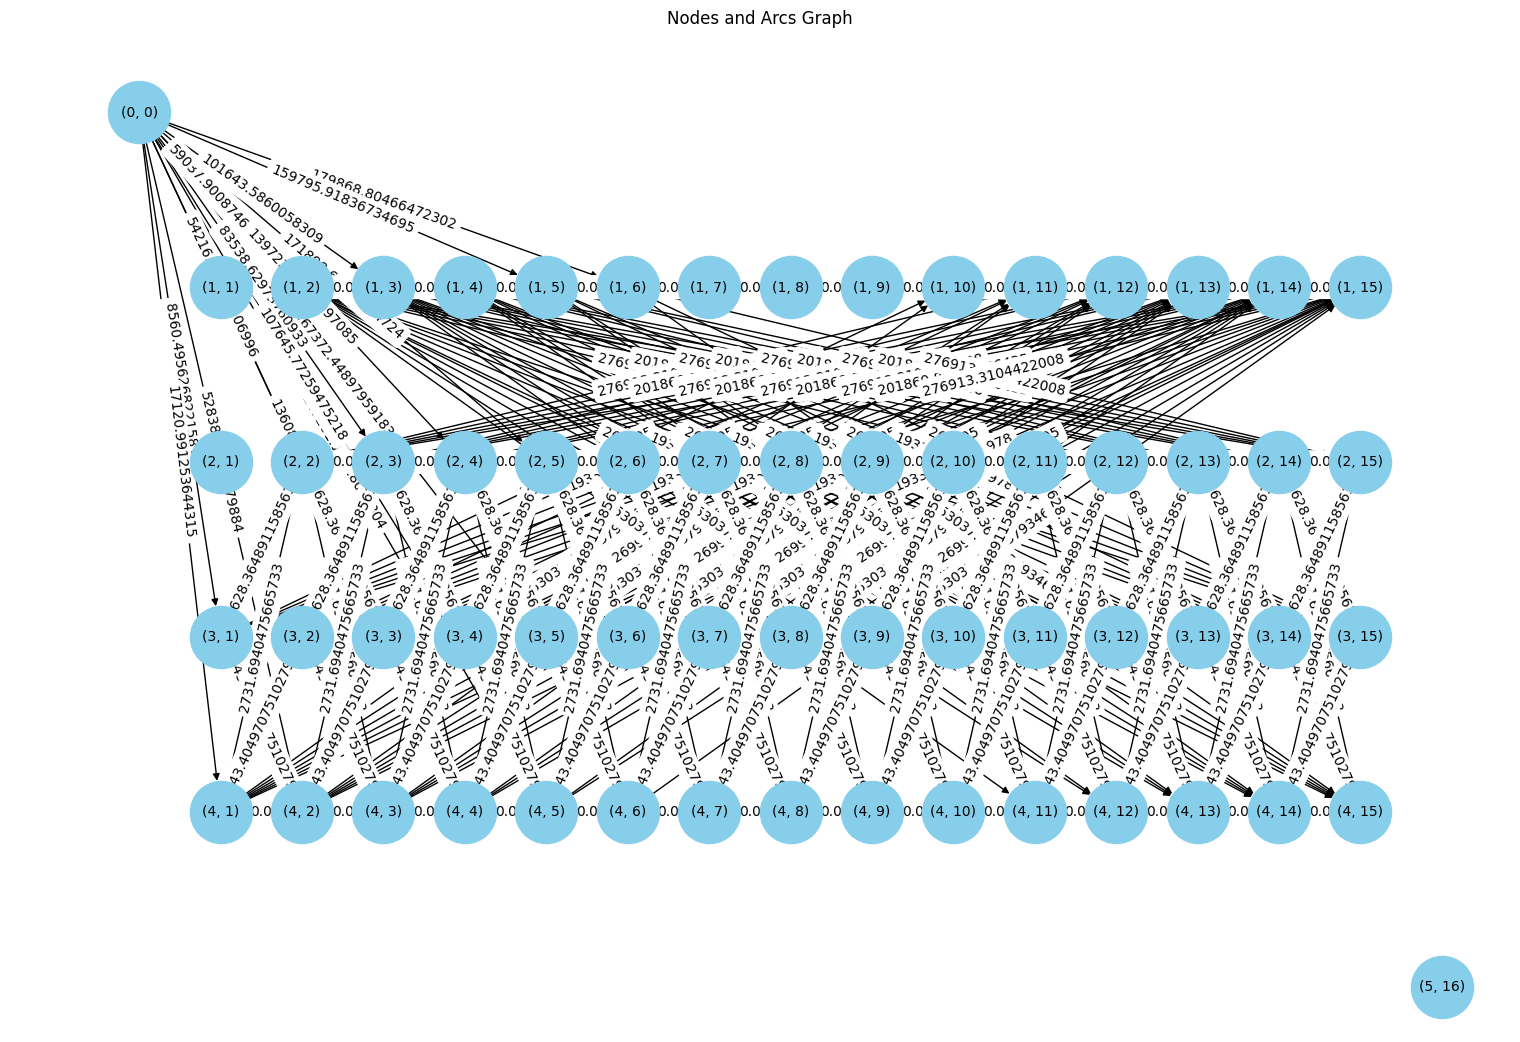

In [141]:
# Visualize the network

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in arc_dict.values():
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple), weight=arc.cost)

# Resetting the y_offset and y_spacing
y_offset = 10
y_spacing = -30  # Increase vertical spacing for better clarity

# Manually specify the positions for each node
pos = {}

# Manually set the position for the source and sink nodes
pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

for node in nodes:
    # Skip setting position for source and sink nodes
    if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        continue
    port_index = node.port.number  # Get port number to determine y-coordinate
    # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
    pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()

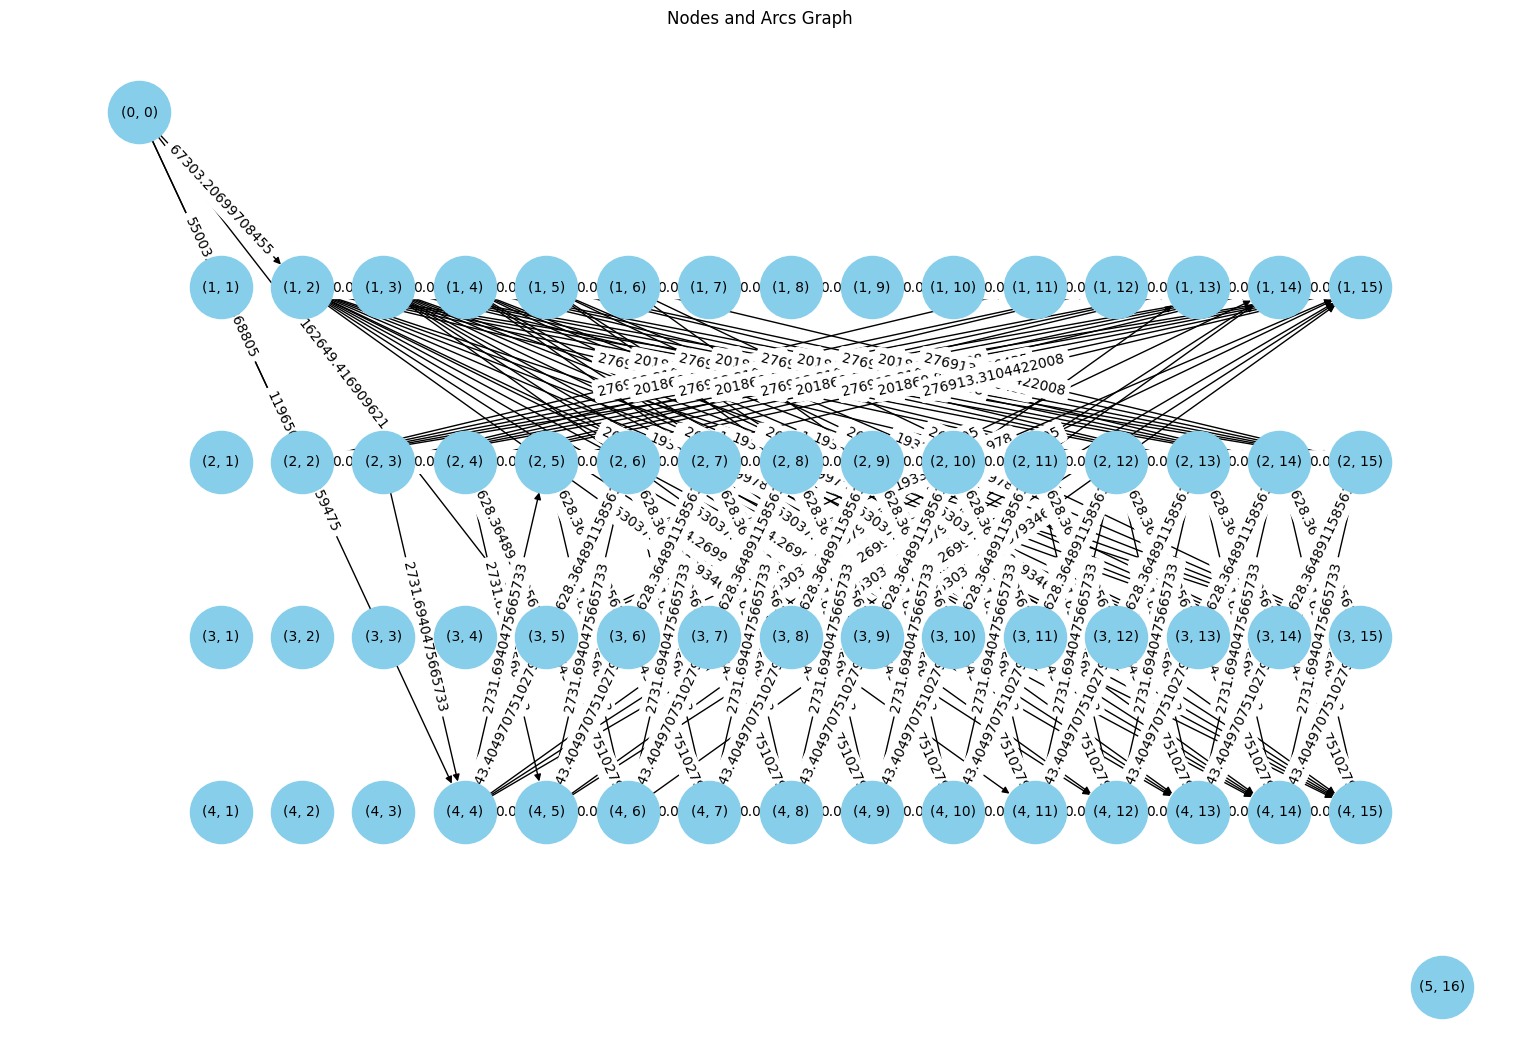

In [142]:
# Visualize the network for vessel 1
vessel = vessels[0]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in vessel_arcs[vessel]:
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple), weight=arc.cost)

# Resetting the y_offset and y_spacing
y_offset = 10
y_spacing = -30  # Increase vertical spacing for better clarity

# Manually specify the positions for each node
pos = {}

# Manually set the position for the source and sink nodes
pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

for node in nodes:
    # Skip setting position for source and sink nodes
    if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        continue
    port_index = node.port.number  # Get port number to determine y-coordinate
    # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
    pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()

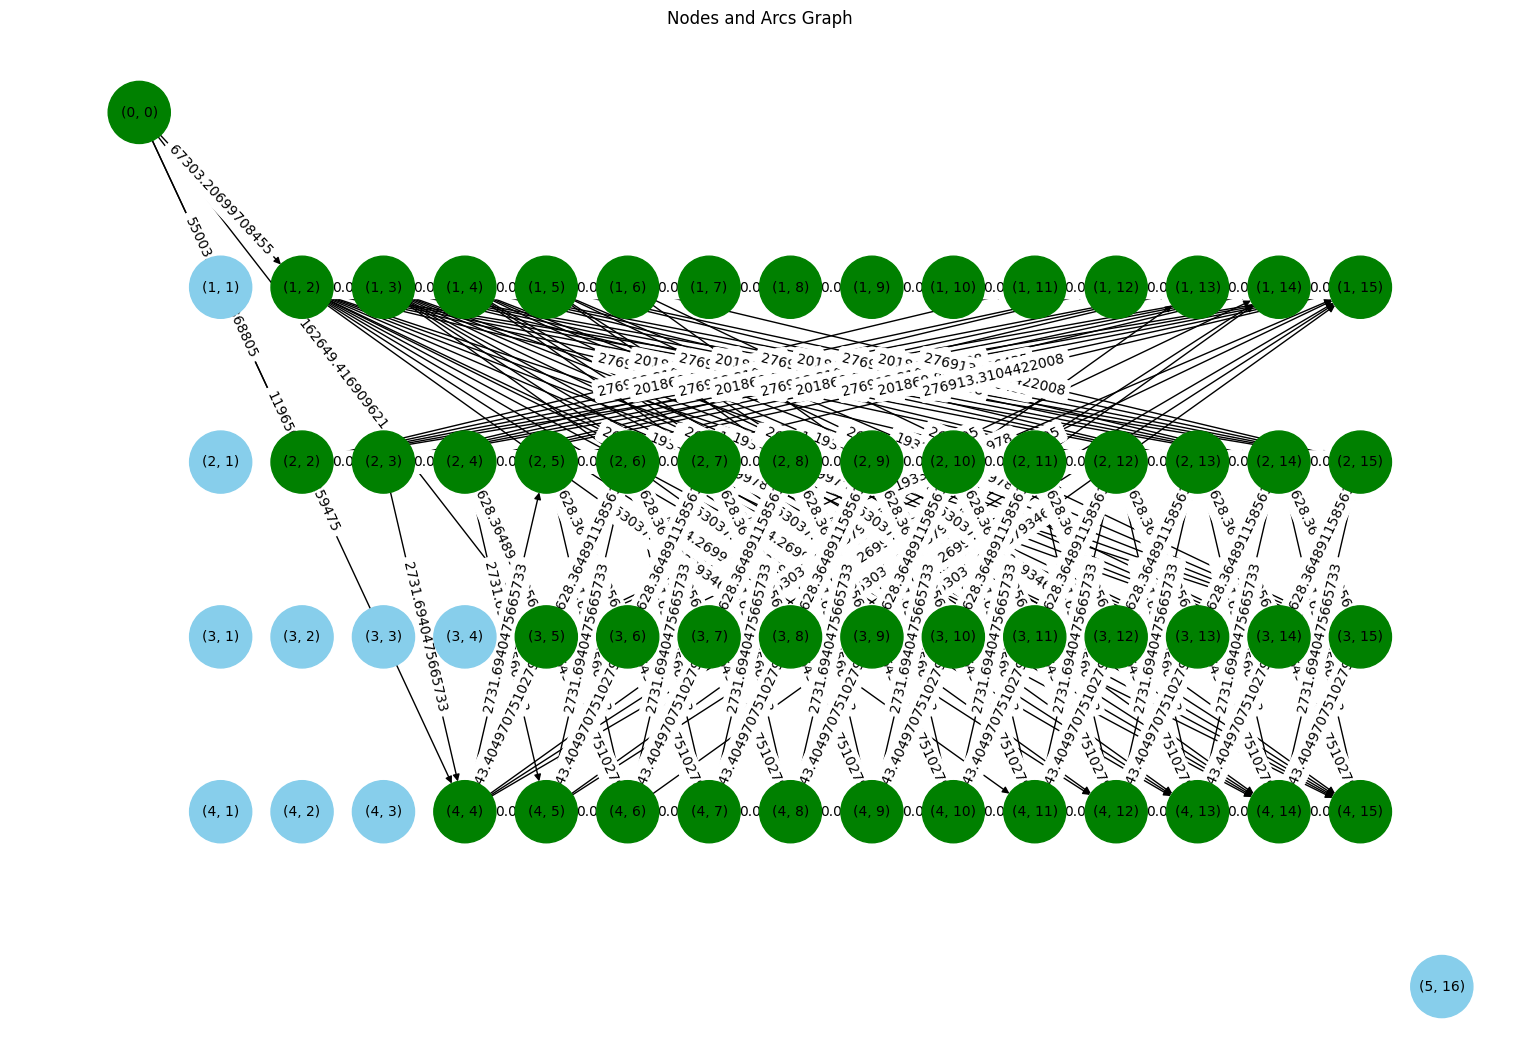

In [143]:
# Visualize the network for vessel 1
vessel = vessels[0]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in vessel_arcs[vessel]:
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple), weight=arc.cost)

# Determine nodes with incoming and outgoing arcs
nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

# Create a list to hold node colors
node_colors = []
for node in G.nodes():
    if node in nodes_with_incoming_arcs or node in nodes_with_outgoing_arcs:
        node_colors.append('green')  # Color for nodes with arcs
    else:
        node_colors.append('skyblue')  # Default color

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()


In [108]:
# source arcs for vessel 1
for arc in source_arcs[vessels[0]]:
    print(arc)
    

(0, 0) -> (1, 2) --- Cost: 67303.20699708455 --- Speed: 15
(0, 0) -> (2, 2) --- Cost: 55003.644314868805 --- Speed: 15
(0, 0) -> (3, 5) --- Cost: 162649.416909621 --- Speed: 15
(0, 0) -> (4, 4) --- Cost: 119650.14577259475 --- Speed: 15


In [109]:
# Add one from the source node to the sink node for every vessel
for vessel in vessels:
    arc = Arc(origin_node=sourceNode, destination_node=sinkNode, distance=0, cost=0, travel_time=0, speed=0)
    sourceNode.outgoing_arcs.add(arc)
    sinkNode.incoming_arcs.add(arc)
    arc_dict[(sourceNode.tuple, sinkNode.tuple, vessel)] = arc
    vessel_arcs.setdefault(vessel, []).append(arc)
    
# Add one arc from every node to the sink node for every vessel
for vessel in vessels:
    for node in nodeDict.values():
        # Skip the source and sink nodes
        if node.port.number in [0, len(ports) + 1]:
            continue
        
        # If the node is before the earliest start time, skip it
        start_time = source_times[vessel][node.port.number - 1]
        if node.time < start_time:
            print(f"Skipped node {node} for vessel {vessel} due to start time {start_time}.")
            continue
        
        
        # Create an arc from the node to the sink node
        arc = Arc(origin_node=node, destination_node=sinkNode, distance=0, cost=0, travel_time=0, speed=0)
        node.outgoing_arcs.add(arc)
        sinkNode.incoming_arcs.add(arc)
        arc_dict[(node.tuple, sinkNode.tuple, vessel)] = arc
        vessel_arcs.setdefault(vessel, []).append(arc)
        
        

Skipped node (1, 1) for vessel Vessel 1 due to start time 2.
Skipped node (2, 1) for vessel Vessel 1 due to start time 2.
Skipped node (3, 1) for vessel Vessel 1 due to start time 5.
Skipped node (4, 1) for vessel Vessel 1 due to start time 4.
Skipped node (3, 2) for vessel Vessel 1 due to start time 5.
Skipped node (4, 2) for vessel Vessel 1 due to start time 4.
Skipped node (3, 3) for vessel Vessel 1 due to start time 5.
Skipped node (4, 3) for vessel Vessel 1 due to start time 4.
Skipped node (3, 4) for vessel Vessel 1 due to start time 5.
Skipped node (1, 1) for vessel Vessel 2 due to start time 3.
Skipped node (2, 1) for vessel Vessel 2 due to start time 3.
Skipped node (3, 1) for vessel Vessel 2 due to start time 5.
Skipped node (4, 1) for vessel Vessel 2 due to start time 4.
Skipped node (1, 2) for vessel Vessel 2 due to start time 3.
Skipped node (2, 2) for vessel Vessel 2 due to start time 3.
Skipped node (3, 2) for vessel Vessel 2 due to start time 5.
Skipped node (4, 2) for 

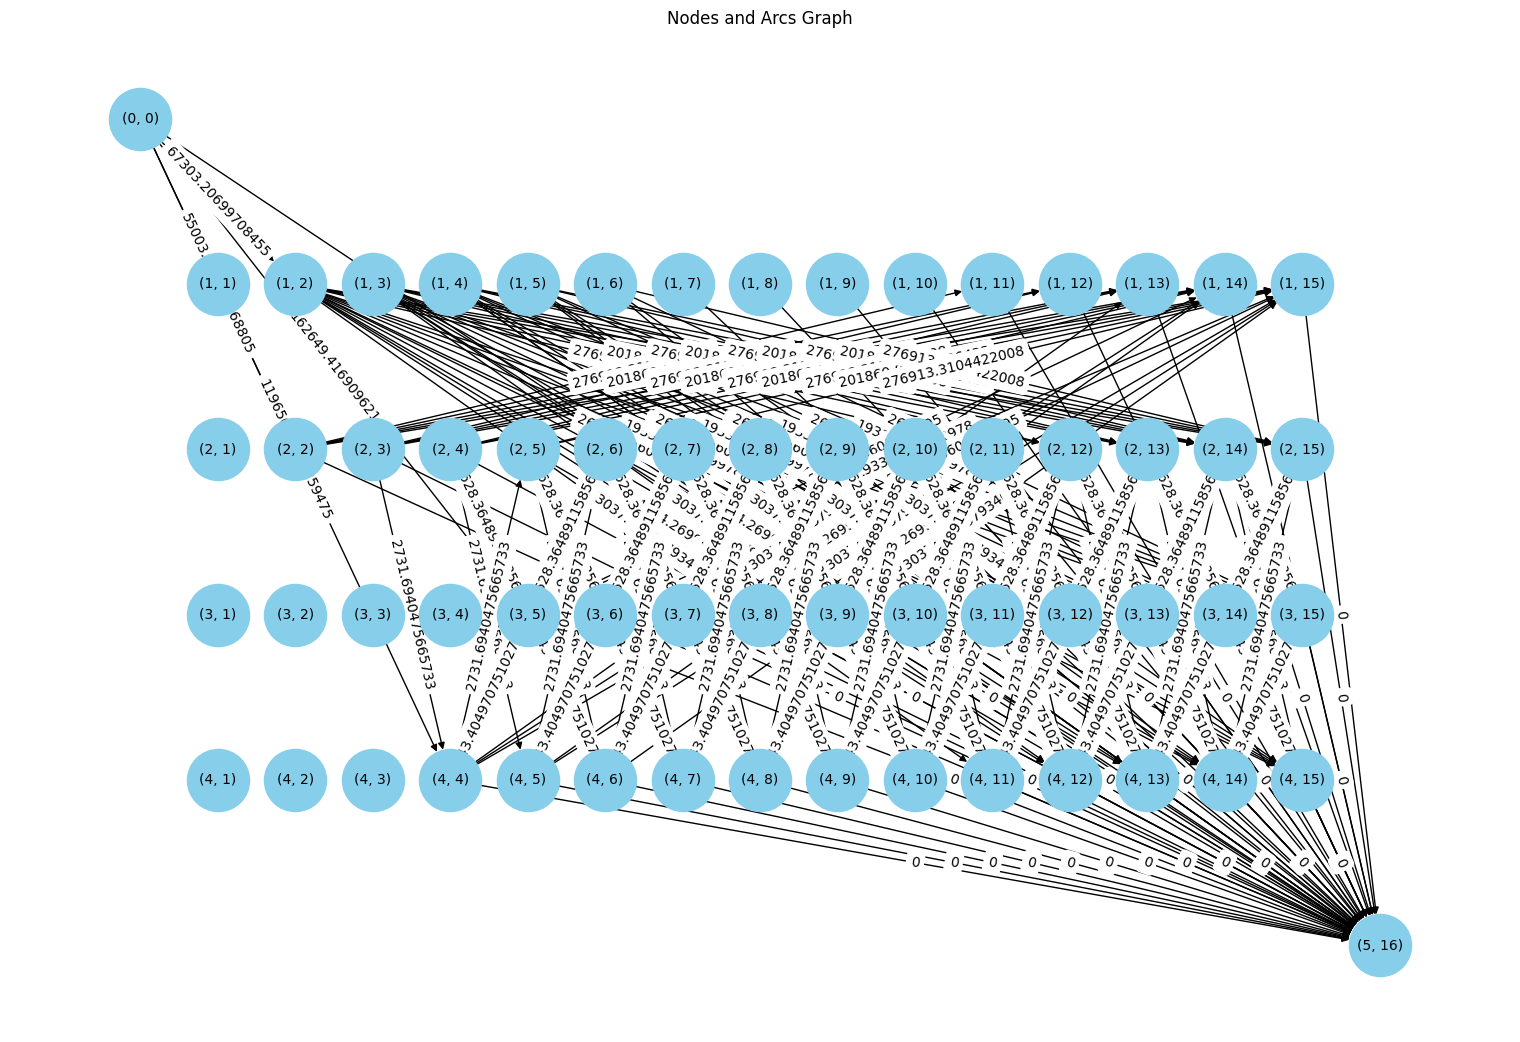

In [110]:
# Visualize the network for vessel 1
vessel = vessels[0]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in vessel_arcs[vessel]:
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple), weight=arc.cost)

# Resetting the y_offset and y_spacing
y_offset = 10
y_spacing = -30  # Increase vertical spacing for better clarity

# Manually specify the positions for each node
pos = {}

# Manually set the position for the source and sink nodes
pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

for node in nodes:
    # Skip setting position for source and sink nodes
    if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        continue
    port_index = node.port.number  # Get port number to determine y-coordinate
    # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
    pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()

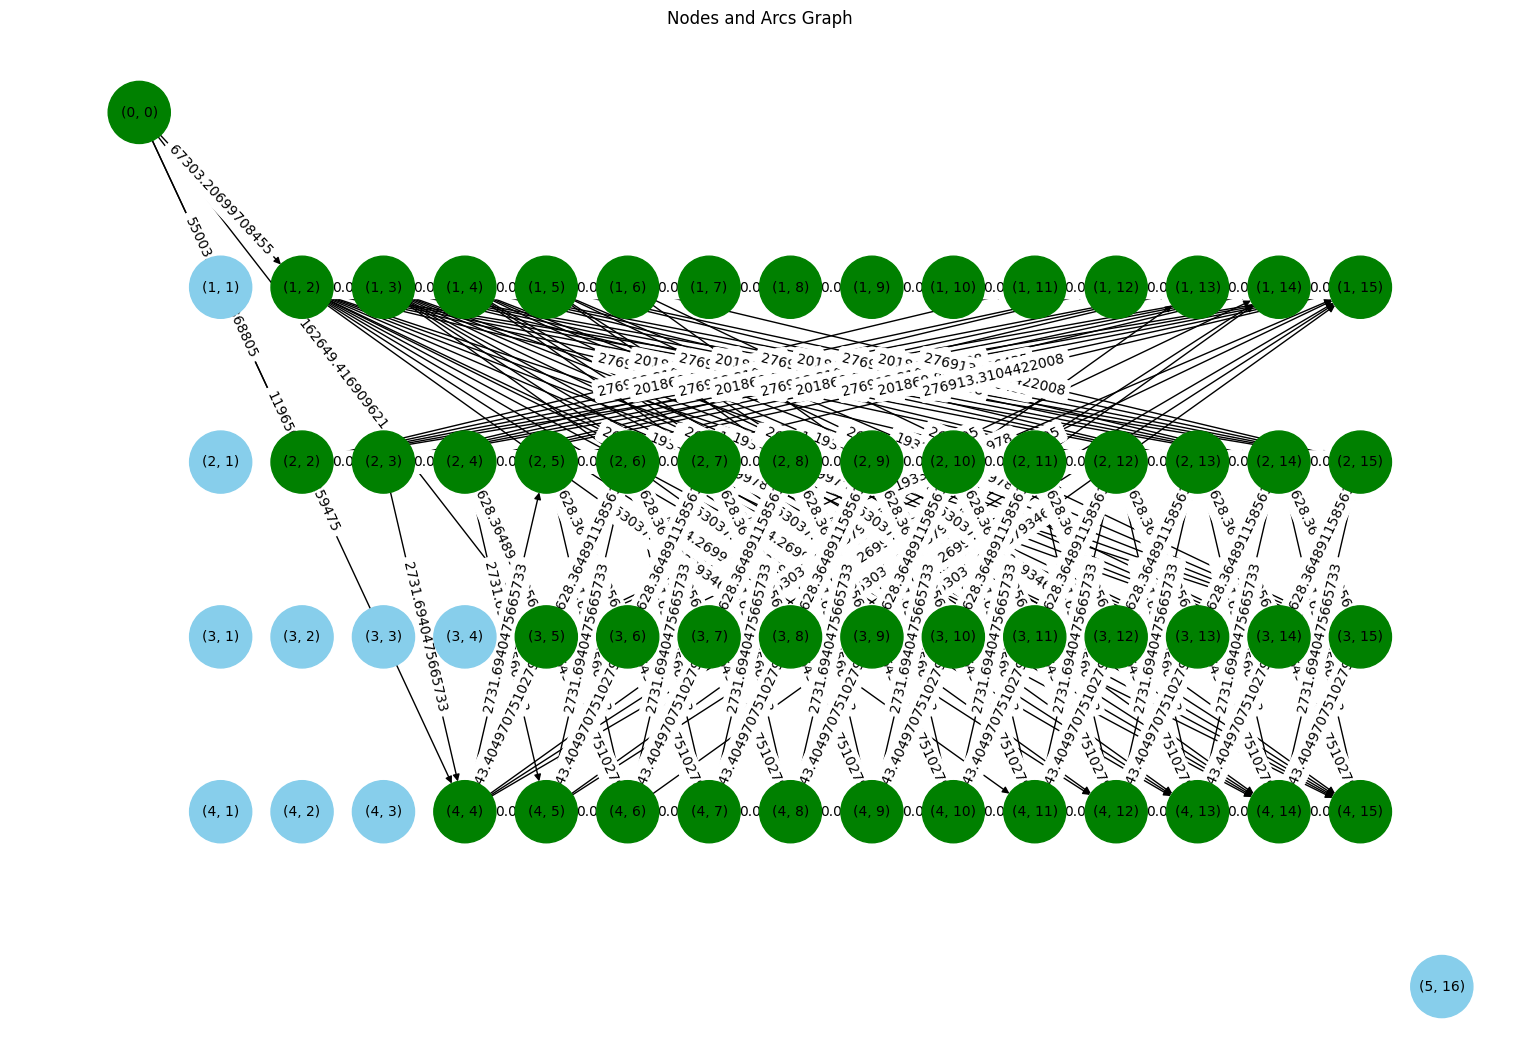

In [145]:
# Visualize the network for vessel 1
vessel = vessels[0]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in vessel_arcs[vessel]:
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple), weight=arc.cost)

# Determine nodes with incoming and outgoing arcs
nodes_with_incoming_arcs = [node for node, degree in G.in_degree() if degree > 0]
nodes_with_outgoing_arcs = [node for node, degree in G.out_degree() if degree > 0]

# Create a list to hold node colors
node_colors = []
for node in G.nodes():
    if node in nodes_with_incoming_arcs or node in nodes_with_outgoing_arcs:
        node_colors.append('green')  # Color for nodes with arcs
    else:
        node_colors.append('skyblue')  # Default color

# Resetting the y_offset and y_spacing
y_offset = 10
y_spacing = -30  # Increase vertical spacing for better clarity

# Manually specify the positions for each node
pos = {}

# Manually set the position for the source and sink nodes
pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

for node in nodes:
    # Skip setting position for source and sink nodes
    if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        continue
    port_index = node.port.number  # Get port number to determine y-coordinate
    # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
    pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color=node_colors, font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()


Still some arcs that are wrong. (2,2) to (4,3) should not exist, since start time for vessel 1 for port 4 is 4. 

In [73]:
source_times

{Vessel 1: [2, 2, 5, 4],
 Vessel 2: [3, 3, 5, 4],
 Vessel 3: [3, 5, 1, 5],
 Vessel 4: [6, 2, 4, 5],
 Vessel 5: [2, 4, 1, 2],
 Vessel 6: [5, 2, 1, 1],
 Vessel 7: [5, 3, 5, 2]}

In [74]:
source_distances

{Vessel 1: array([ 684,  559, 1653, 1216]),
 Vessel 2: array([ 835,  763, 1731, 1383]),
 Vessel 3: array([1033, 1747,  277, 1778]),
 Vessel 4: array([1828,  599, 1094, 1496]),
 Vessel 5: array([ 600, 1420,  314,  705]),
 Vessel 6: array([1510,  551,   87,  174]),
 Vessel 7: array([1624,  849, 1701,  537])}

In [75]:
# For each vessel, find the earliest time period it is able to reach each port
vessel_starting_times = {}
for vessel, distances in source_distances.items():
    # Create a list of the earliest time period for each port
    earliest_times = []
    for distance in distances:
        # Calculate the earliest time period and the speed
        minimum_timesteps, speed = calculate_minimum_timesteps_and_speed(distance_nm=distance, max_speed_k=max_speed_k, min_speed_k=min_speed_k)
        earliest_times.append(minimum_timesteps)
    vessel_starting_times[vessel] = earliest_times

In [76]:
vessel_starting_times

{Vessel 1: [2, 2, 5, 4],
 Vessel 2: [3, 3, 5, 4],
 Vessel 3: [3, 5, 1, 5],
 Vessel 4: [6, 2, 4, 5],
 Vessel 5: [2, 4, 1, 2],
 Vessel 6: [5, 2, 1, 1],
 Vessel 7: [5, 3, 5, 2]}

In [77]:
# Use the vessel_starting_times to create the sets of arcs for each vessel.
# First extract all arcs from the arc_dict
all_arcs = list(arc_dict.values())

for vessel in vessels:
    # Create a new set of arcs for each vessel
    vessel.arcs = set()
    # Extract the starting times for the vessel
    starting_times = vessel_starting_times[vessel]
    # Loop through all arcs
    for arc in all_arcs:
        for starting_time in starting_times:
            # Find the port number based on the index of the starting time
            port_number = starting_times.index(starting_time) + 1
            if starting_time > arc.origin_node.time:
                continue
            if starting_time > arc.destination_node.time:
                continue
            
        # If the starting time 

In [23]:
'''Using the parsed data instead'''

# Create the set of arcs associated with vessel v in a time-space model
# Note: The arcs need to be revised so that only feasible travels are included
def generate_all_arcs(regularNodes, vesselClass):
    arc_dict = {}
    vessels_in_vessel_class = vessels[vesselClass]
    for v in vessels_in_vessel_class:
        # Arcs between all nodes
        for n in regularNodes:
            arcs = set()
            outgoing_arcs_for_node_n_vessel_v = outgoing_arcs_v2(node=n, nodes=nodes, vessel=v, vessel_class=vessel_class)
            arcs.update(outgoing_arcs_for_node_n_vessel_v)
            arc_dict[(n.tuple, v)] = arcs
    return arc_dict

In [24]:
# Create the arcs
numVesselClasses = metadata_from_content['numVesselClasses']
all_arcs = {}
for c in range(numVesselClasses):
    all_arcs[c] = generate_all_arcs(regularNodes, c)

In [25]:
print(all_arcs)

{0: {((1, 1), Vessel 1): {(1, 1) -> (3, 3), (1, 1) -> (2, 6), (1, 1) -> (4, 6), (1, 1) -> (3, 2), (1, 1) -> (3, 4), (1, 1) -> (1, 4), (1, 1) -> (4, 3), (1, 1) -> (1, 6), (1, 1) -> (2, 4), (1, 1) -> (2, 3), (1, 1) -> (2, 2), (1, 1) -> (3, 6), (1, 1) -> (1, 5), (1, 1) -> (4, 5), (1, 1) -> (4, 2), (1, 1) -> (3, 5), (1, 1) -> (1, 3), (1, 1) -> (1, 2), (1, 1) -> (2, 5), (1, 1) -> (4, 4)}, ((2, 1), Vessel 1): {(2, 1) -> (1, 3), (2, 1) -> (4, 2), (2, 1) -> (2, 6), (2, 1) -> (1, 6), (2, 1) -> (3, 3), (2, 1) -> (4, 4), (2, 1) -> (1, 2), (2, 1) -> (2, 5), (2, 1) -> (4, 6), (2, 1) -> (4, 3), (2, 1) -> (3, 5), (2, 1) -> (3, 2), (2, 1) -> (2, 4), (2, 1) -> (2, 3), (2, 1) -> (2, 2), (2, 1) -> (3, 6), (2, 1) -> (3, 4), (2, 1) -> (1, 4), (2, 1) -> (1, 5), (2, 1) -> (4, 5)}, ((3, 1), Vessel 1): {(3, 1) -> (3, 5), (3, 1) -> (3, 4), (3, 1) -> (4, 3), (3, 1) -> (2, 3), (3, 1) -> (4, 2), (3, 1) -> (3, 6), (3, 1) -> (4, 4), (3, 1) -> (1, 6), (3, 1) -> (4, 6), (3, 1) -> (2, 2), (3, 1) -> (1, 4), (3, 1) -> (1

In [26]:
total_arcs = 0
for c in range(numVesselClasses):
    for n in regularNodes:
        for v in vessels[c]:
            total_arcs += len(all_arcs[c][(n.tuple, v)])
            
total_arcs

1680

In [27]:
# Add the arcs from sourceNode to all regular nodes and from all regular nodes to sinkNode
for c in range(numVesselClasses):
    for vessel in vessels[c]:
        for n in regularNodes:
            arc_set = set()
            arc_set.add(Arc(origin_node=sourceNode, destination_node=n, vessel=vessel, distance=0, cost=0, travel_time=0))
            arc_set.add(Arc(origin_node=n, destination_node=sinkNode, vessel=vessel, distance=0, cost=0, travel_time=0))
            if (n.tuple, vessel) not in all_arcs[c]:
                all_arcs[c][(n.tuple, vessel)] = set()
            all_arcs[c][(n.tuple, vessel)].update(arc_set)

            
# Add one arc from sourceNode to sinkNode
for c in range(numVesselClasses):
    for vessel in vessels[c]:
        all_arcs[c][sourceNode.tuple, vessel] = {Arc(origin_node=sourceNode, destination_node=sinkNode, vessel=vessel, distance=0, cost=0, travel_time=0)}
    
    
# Add an empty set for the sinkNode
for c in range(numVesselClasses):
    for vessel in vessels[c]:
        all_arcs[c][sinkNode.tuple, vessel] = {}
    
print(all_arcs)

{0: {((1, 1), Vessel 1): {(1, 1) -> (3, 3), (1, 1) -> (2, 6), (1, 1) -> (4, 6), (1, 1) -> (3, 2), (1, 1) -> (3, 4), (0, 0) -> (1, 1), (1, 1) -> (1, 4), (1, 1) -> (4, 3), (1, 1) -> (5, 7), (1, 1) -> (1, 6), (1, 1) -> (2, 4), (1, 1) -> (2, 3), (1, 1) -> (2, 2), (1, 1) -> (3, 6), (1, 1) -> (1, 5), (1, 1) -> (4, 5), (1, 1) -> (4, 2), (1, 1) -> (3, 5), (1, 1) -> (1, 3), (1, 1) -> (1, 2), (1, 1) -> (2, 5), (1, 1) -> (4, 4)}, ((2, 1), Vessel 1): {(2, 1) -> (1, 3), (2, 1) -> (4, 2), (2, 1) -> (2, 6), (2, 1) -> (1, 6), (2, 1) -> (3, 3), (2, 1) -> (4, 4), (2, 1) -> (1, 2), (2, 1) -> (2, 5), (2, 1) -> (4, 6), (2, 1) -> (4, 3), (0, 0) -> (2, 1), (2, 1) -> (5, 7), (2, 1) -> (3, 5), (2, 1) -> (3, 2), (2, 1) -> (2, 4), (2, 1) -> (2, 3), (2, 1) -> (2, 2), (2, 1) -> (3, 6), (2, 1) -> (3, 4), (2, 1) -> (1, 4), (2, 1) -> (1, 5), (2, 1) -> (4, 5)}, ((3, 1), Vessel 1): {(3, 1) -> (3, 5), (3, 1) -> (3, 4), (3, 1) -> (4, 3), (3, 1) -> (2, 3), (3, 1) -> (4, 2), (3, 1) -> (3, 6), (3, 1) -> (4, 4), (3, 1) -> (1

In [28]:
all_arcs[0]

{((1, 1), Vessel 1): {(0, 0) -> (1, 1),
  (1, 1) -> (1, 2),
  (1, 1) -> (1, 3),
  (1, 1) -> (1, 4),
  (1, 1) -> (1, 5),
  (1, 1) -> (1, 6),
  (1, 1) -> (2, 2),
  (1, 1) -> (2, 3),
  (1, 1) -> (2, 4),
  (1, 1) -> (2, 5),
  (1, 1) -> (2, 6),
  (1, 1) -> (3, 2),
  (1, 1) -> (3, 3),
  (1, 1) -> (3, 4),
  (1, 1) -> (3, 5),
  (1, 1) -> (3, 6),
  (1, 1) -> (4, 2),
  (1, 1) -> (4, 3),
  (1, 1) -> (4, 4),
  (1, 1) -> (4, 5),
  (1, 1) -> (4, 6),
  (1, 1) -> (5, 7)},
 ((2, 1), Vessel 1): {(0, 0) -> (2, 1),
  (2, 1) -> (1, 2),
  (2, 1) -> (1, 3),
  (2, 1) -> (1, 4),
  (2, 1) -> (1, 5),
  (2, 1) -> (1, 6),
  (2, 1) -> (2, 2),
  (2, 1) -> (2, 3),
  (2, 1) -> (2, 4),
  (2, 1) -> (2, 5),
  (2, 1) -> (2, 6),
  (2, 1) -> (3, 2),
  (2, 1) -> (3, 3),
  (2, 1) -> (3, 4),
  (2, 1) -> (3, 5),
  (2, 1) -> (3, 6),
  (2, 1) -> (4, 2),
  (2, 1) -> (4, 3),
  (2, 1) -> (4, 4),
  (2, 1) -> (4, 5),
  (2, 1) -> (4, 6),
  (2, 1) -> (5, 7)},
 ((3, 1), Vessel 1): {(0, 0) -> (3, 1),
  (3, 1) -> (1, 2),
  (3, 1) -> (1, 3)

In [29]:
# # Create a set of all arcs no matter what the vessel and vessel class is
# all_arcs_set = set()
# for c in range(numVesselClasses):
#     for n in nodes:
#         for v in vessels[c]:
#             # If we have an arc that have the same representation, we only add one of them
            
            
            
all_arcs_set = set()
for c in range(numVesselClasses):
    for n in nodes:
        for v in vessels[c]:
            # Check each arc in the current vessel class, node, and vessel combination
            for arc in all_arcs[c][(n.tuple, v)]:
                # If the representation of the arc isn't in the set, add the arc itself
                if arc.__repr__() not in all_arcs_set:
                    all_arcs_set.add(arc)

            
#Create a set of arcs for each vessel:
for c in vessels:
    for v in vessels[c]:
        arc_set = set()
        for arc in all_arcs_set:
            if arc.vessel == v:
                arc_set.add(arc)
        v.arcs = arc_set

In [30]:
# Create the arcs for each node

for n in nodes:
    for a in all_arcs_set:
        if a.origin_node.tuple == n.tuple:
            n.outgoing_arcs.add(a)
        if a.destination_node.tuple == n.tuple:
            n.incoming_arcs.add(a)

## Visualization of graph

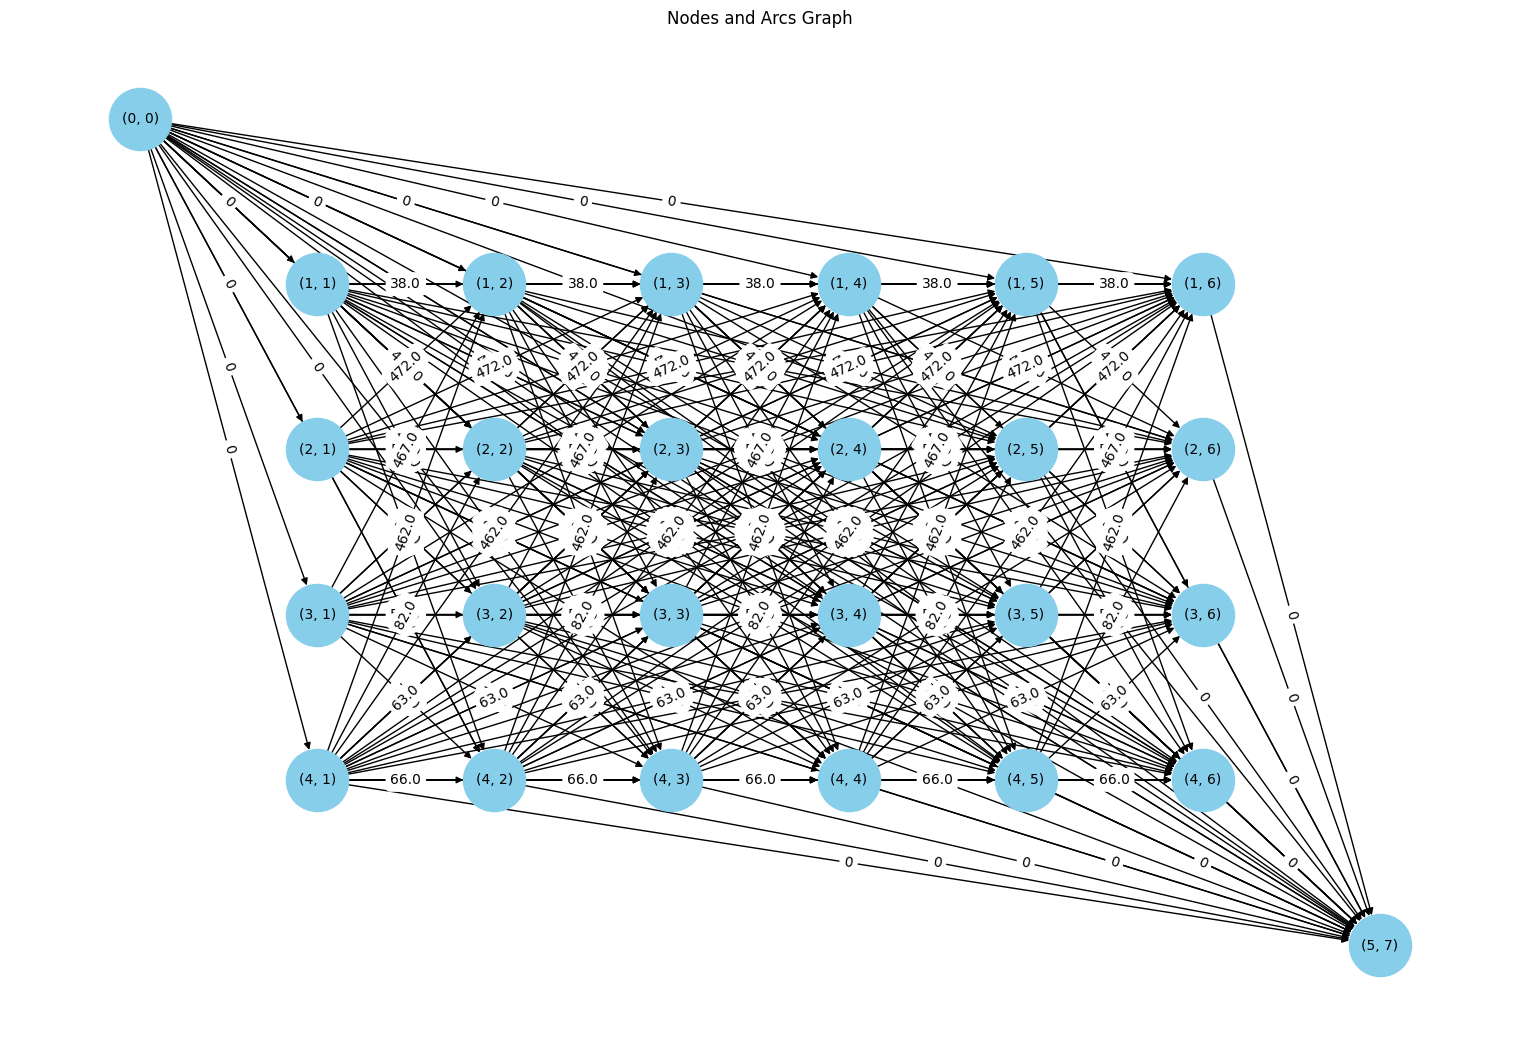

In [31]:
# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for node in nodes:
    G.add_node(str(node.tuple))

# Add edges (arcs) to the graph
for arc in all_arcs_set:
    G.add_edge(str(arc.origin_node.tuple), str(arc.destination_node.tuple), weight=arc.cost)

# Resetting the y_offset and y_spacing
y_offset = 10
y_spacing = -30  # Increase vertical spacing for better clarity

# Manually specify the positions for each node
pos = {}

# Manually set the position for the source and sink nodes
pos["(0, 0)"] = (0, 0)  # Positioning source node at leftmost, middle height
pos["(5, 5)"] = (5 * 10, 0)  # Positioning sink node at rightmost, middle height

for node in nodes:
    # Skip setting position for source and sink nodes
    if str(node.tuple) in ["(0, 0)", "(5, 5)"]:
        continue
    port_index = node.port.number  # Get port number to determine y-coordinate
    # The x-coordinate is based on time, the y-coordinate is fixed for nodes with the same port
    pos[str(node.tuple)] = (node.time * 10, port_index * y_spacing)  # Multiplying time by 10 for better horizontal spacing

# Drawing the graph using the adjusted positions
plt.figure(figsize=(15, 10))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color="skyblue", font_size=10)
labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=labels)
plt.title("Nodes and Arcs Graph")
plt.show()


All nodes and arcs have been created. However there are arcs between all nodes, even though it may be infeasible for a vessel to travel the distance in time. 

We should therefore remove some of the arcs, based on feasiblity in regards to the speed. 

In addition, in the beginning of the planning period, if the vessel inventory is empty, we can remove all the arcs that go to discharging ports.
### Unsure how to solve the initial problem when vessels have different starting locations. The distance to the ports will then vary. 


# Starting with Gurobi

In [32]:
vessels

{0: [Vessel 1, Vessel 2, Vessel 3, Vessel 4, Vessel 5, Vessel 6, Vessel 7]}

In [33]:
'''Creating the variables'''
'''Binary first'''
# x is the binary variable that indicates whether a vessel travels on arc a, where and arc is a route frome one node to another node. 
x = m.addVars((arc.tuple for arc in all_arcs_set), vtype=gp.GRB.BINARY, name="x")

# o is the binary variable that indicates whether vessel v is operating (loading/unloading) at port p at time t
o = m.addVars(((port.number, t, vessel) for port in ports for t in timePeriodRange for c in vessels for vessel in vessels[c]), vtype=gp.GRB.BINARY, name="o")

'''Continuous varibles'''
# q is the amount of product loaded or unloaded at port i by vessel v at time t
q_bounds = {(port.number, t, vessel): min(vessel.max_inventory, port.capacity) for port in ports for t in timePeriodRange for c in vessels for vessel in vessels[c]}
q = m.addVars(q_bounds.keys(), lb=0, ub=q_bounds, vtype=gp.GRB.CONTINUOUS, name="q")

# s is the amount of product at port i at the end of period t
s_bounds = {(port.number, t): port.capacity for port in ports for t in timePeriodRange}
s = m.addVars(s_bounds.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")
# Create s vars for each port in time period 0
s_bounds_source = {(port.number, 0): port.capacity for port in ports}
s_source = m.addVars(s_bounds_source.keys(), lb=0, ub=s_bounds, vtype=gp.GRB.CONTINUOUS, name="s")
s.update(s_source)

# w is the amount of product on board of vessel v at the end of time period t
w_bounds = {(t, vessel): vessel.max_inventory for c in vessels for vessel in vessels[c] for t in timePeriodRange}
w = m.addVars(w_bounds.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w_bounds_source = {(0, vessel): vessel.max_inventory for c in vessels for vessel in vessels[c]}
w_source = m.addVars(w_bounds_source.keys(), lb=0, ub=w_bounds, vtype=gp.GRB.CONTINUOUS, name="w")
w.update(w_source)

m.update()

In [34]:
# Create a dict where the arc.tuple is the key and arc.cost is the value
'''
costs = {(arc.tuple): arc.cost for arc in all_arcs_set}
''' 
costs = {(arc.tuple): arc.cost for c in vessels for v in vessels[c] for arc in v.arcs}
m.update()

### Objective Function

In [35]:
obj = gp.quicksum(costs[key]*x[key] for key in costs)

#Minimize the costs
m.setObjective(obj, GRB.MINIMIZE)

m.update()

### Constraints

In [36]:
# Constraint (2)
'''
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        m.addConstr(gp.quicksum(x[arc.tuple] for arc in sourceNode.outgoing_arcs) == 1, name = 'SourceFlow')
'''

for c in vessels:
    for v in vessels[c]:
        m.addConstr(gp.quicksum(x[arc.tuple] for arc in sourceNode.outgoing_arcs if arc.vessel == v) == 1, name = 'SourceFlow')
m.update()

In [37]:
# Constraint (3)
'''
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        m.addConstr(gp.quicksum(x[arc.tuple] for arc in sinkNode.incoming_arcs) == 1, name = 'SinkFlow')
'''
for c in vessels:
    for v in vessels[c]:
        m.addConstr(gp.quicksum(x[arc.tuple] for arc in sinkNode.incoming_arcs if arc.vessel == v) == 1, name = 'SinkFlow')

In [38]:
# Constraint (4)
# Creating a flow balance constraint for each node
'''
for c in range(numVesselClasses):
    for i in range(len(vessels[c])):
        for node in regularNodes:
            m.addConstr(gp.quicksum(x[in_arc.tuple] for in_arc in node.incoming_arcs) - gp.quicksum(x[out_arc.tuple] for out_arc in node.outgoing_arcs) == 0, name = "FlowBalance")
'''
for c in vessels:
    for v in vessels[c]:
        for node in regularNodes:
            m.addConstr(gp.quicksum(x[in_arc.tuple] for in_arc in node.incoming_arcs if in_arc.vessel == v) - gp.quicksum(x[out_arc.tuple] for out_arc in node.outgoing_arcs if out_arc.vessel == v) == 0, name = "FlowBalance")

In [39]:
s_bounds.keys()

dict_keys([(1, 1), (1, 2), (1, 3), (1, 4), (1, 5), (1, 6), (2, 1), (2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6)])

In [40]:
# Constraint (5)
for port in ports:
    m.addConstr(s_source[port.number, 0] == port.inventory, name = 'InitialInventoryPort')

In [41]:
# Constraint (6)
'''Rate is static for now'''
'''
for node in regularNodes:
    m.addConstr(s[node.port.number, node.time] == (s[node.port.number, node.time-1] + (node.port.isLoadingPort * node.port.rate) - gp.quicksum(node.port.isLoadingPort * q[node.port.number, node.time, v] for c in vessels for v in vessels[c])) , name = 'InventoryBalance')

m.update()
'''

#inventory balance for ports at the end of each time period t
for port in ports:
    for t in timePeriodRange:
        m.addConstr(s[port.number, t] == (s[port.number, t-1] + (port.isLoadingPort * port.rate) - gp.quicksum(port.isLoadingPort * q[port.number, t, v] for c in vessels for v in vessels[c])) , name = 'InventoryBalance')
m.update()




In [42]:
for port in ports:
    print(port.isLoadingPort)

1
-1
-1
-1


In [43]:
# Constraint (7)
'''
for c in range(numVesselClasses):
    for v in vessels[c]:
        m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')
'''
for c in vessels:
    for v in vessels[c]:
        m.addConstr(w_source[0, v] == v.inventory, name = 'InitialInventoryVessel')

In [44]:
# Constraint (8)
'''
for c in range(numVesselClasses):
    for v in vessels[c]:
        for t in timePeriodRange:
            m.addConstr(w[t, v] == w[t-1, v] + gp.quicksum(node.port.isLoadingPort * q[node.port.number, t, v] for node in regularNodes), name = 'VesselBalance')
'''
# for each vessel, the inventory at the end of the time period is equal to the inventory at the beginning of the time period + the amount of product loaded/unloaded at the ports
for t in timePeriodRange:
    for c in vessels:
        for v in vessels[c]:
            m.addConstr(w[t, v] == gp.quicksum(port.isLoadingPort * q[port.number, t, v] for port in ports) + w[t-1,v], name = 'VesselBalance')
m.update()

In [45]:
# Constraint (9)
'''
for node in regularNodes:
    m.addConstr((gp.quicksum(o[node.port.number, node.time, v] for c in range(numVesselClasses) for v in vessels[c]) <= node.port.berth_limit), name = 'Birth_limit_in_time_t')
'''
for node in regularNodes:
    m.addConstr((gp.quicksum(o[node.port.number, node.time, v] for c in vessels for v in vessels[c]) <= node.port.berth_limit), name = 'Birth_limit_in_time_t')
m.update()

In [46]:
#Constraint (10)
'''
for c in range(numVesselClasses):
    for v in vessels[c]:
        for node in regularNodes:
            m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum(x[in_arc.tuple] for in_arc in node.incoming_arcs))
'''
for c in vessels:
    for v in vessels[c]:
        for node in regularNodes:
            m.addConstr(o[node.port.number, node.time, v] <= gp.quicksum(x[in_arc.tuple] for in_arc in node.incoming_arcs if in_arc.vessel == v))

In [47]:
#Constraint (11)
for c in vessels:
    for v in vessels[c]:
        for node in regularNodes:
            m.addConstr(q[node.port.number, node.time, v] <= o[node.port.number, node.time, v]*v.max_operating_quantity, name = 'Max_operating_quantity')
m.update()

In [48]:
#optimize the model
# Assuming you have a Gurobi model object named 'model' and a variable named 'arc_vars' representing the arcs

# Optimize the model
m.optimize()

# Check the status of the optimization
if m.status == gp.GRB.OPTIMAL:
    print("Optimal solution found!")

#Access the x variables in order to see which arcs are used in the optimal solution
for v in m.getVars():
    if v.x > 0:
        print(v.varName, v.x)

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[x86])

CPU model: Intel(R) Core(TM) i5-8257U CPU @ 1.40GHz
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 619 rows, 2436 columns and 7045 nonzeros
Model fingerprint: 0x69f14c46
Variable types: 245 continuous, 2191 integer (2191 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+02]
  Objective range  [4e+01, 5e+02]
  Bounds range     [1e+00, 6e+02]
  RHS range        [1e+00, 3e+02]
Presolve removed 51 rows and 305 columns
Presolve time: 0.06s
Presolved: 568 rows, 2131 columns, 5649 nonzeros
Variable types: 216 continuous, 1915 integer (1915 binary)

Root relaxation: objective 0.000000e+00, 77 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0    0.00000    0    6          -    0.00000      -     -    0s
H    0     